#### Tommaso Perniola - tommaso.perniola@studio.unibo.it - 0001146230

# Sea Surface Temperature Reconstruction under cloud occlusion

Sea Surface Temperature (SST) data are mostly acquired by means of satellites detecting the infrared radiation emitted from the sea surface. This radiation can be absorbed by clouds, causing large occlusions in collected observations. Filling these gaps is the task of your exam.

We focus on a region of the north adriatic sea. Data are taken from the MODIS dataset; we use the nigthly data collected by the Aqua satellite.


In [6]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import l2

import matplotlib.pyplot as plt

In [ ]:
seed = 38
tf.random.set_seed(seed)
np.random.seed(seed)

### Download data

In [ ]:
#data
!gdown 1cxZCt2CzMo9AolJ9k-je3b4w9t0Ibpvc
!gdown 1L3PxazNUnc_cw9XvHfj_J-fhhBXv41YY
!gdown 1tR7U8ndBktwiAhmpyQZG2nv5kRcX0mtd
#dates
!gdown 1ROGlbqknu47uyZs89J1oBml6vwE-wtfx
!gdown 1wpKfWxwf9XXJixdUrrjN-idcAZ5H3-0C
!gdown 1hGg-J7ipuil1Hp46YTIVWzXkSHc2avBE

In [ ]:
#land-sea mask
!gdown 1F0GGmrrGtSHizdf0COyHErNqMf9FazCK

In [ ]:
#a statistical baseline
!gdown 1JfVhw5HHlUOj_3UxVFT-kTaOVs6ZRUEJ

### Let us inspect and visualize data.

In [7]:
x_train_n = np.load('/content/x_train_night.npy')
x_val_n = np.load('/content/x_val_night.npy')
x_test_n = np.load('/content/x_test_night.npy')

print(x_train_n.shape)
print(x_val_n.shape)
print(x_test_n.shape)

print(f"min train temperature: {np.nanmin(x_train_n)}")
print(f"max train temperature: {np.nanmax(x_train_n)}")
print(f"mean train temperature: {np.nanmean(x_train_n)}")
print(f"std train temperature: {np.nanstd(x_train_n)}\n")

print(f"min val temperature: {np.nanmin(x_val_n)}")
print(f"max val temperature: {np.nanmax(x_val_n)}\n")

print(f"min test temperature: {np.nanmin(x_test_n)}")
print(f"max test temperature: {np.nanmax(x_test_n)}")


(5832, 128, 128)
(1090, 128, 128)
(895, 128, 128)
min train temperature: 0.08999999612569809
max train temperature: 30.654998779296875
mean train temperature: 19.480466842651367
std train temperature: 5.093418598175049

min val temperature: 1.274999976158142
max val temperature: 29.979999542236328

min test temperature: 2.884999990463257
max test temperature: 30.594999313354492


Let us visualize a few images. Occluded area are coded with nans: they may correspond to land or clouds. nans are rendered in blank.

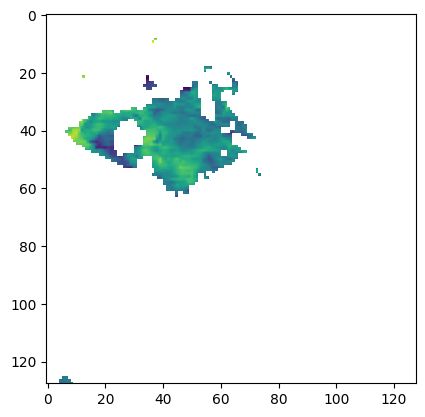

In [8]:
i = np.random.randint(0, x_train_n.shape[0])
plt.imshow(x_train_n[i]); #nans are blank; they could be land or clouds

In [9]:
dates_train_n = np.load('/content/dates_train_night.npy')
dates_val_n = np.load('/content/dates_val_night.npy')
dates_test_n = np.load('/content/dates_test_night.npy')

print(dates_train_n.shape) # from 2002-07-04 to 2018-07-04
print(dates_val_n.shape)   # from 2018-07-04 to 2021-07-04
print(dates_test_n.shape)  # from 2021-07-04 to 2023-12-31

(5832,)
(1090,)
(895,)


We know the part of the territory corresponding to land.
In the land-sea mask, 1 is for sea, and 0 for land.

(128, 128)
sea percentage =  0.408203125


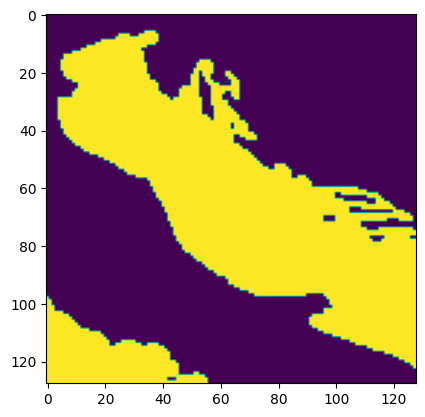

In [10]:
land_sea_mask = np.load('/content/land_sea_mask.npy')
print(land_sea_mask.shape)
plt.imshow(land_sea_mask)
total_sea = np.sum(land_sea_mask)
print("sea percentage = ", total_sea/(128*128))

In [ ]:
baseline = np.load('/content/stat_baseline.npy')
print(baseline.shape) # 365 days | 128x128 image
print(f"min baseline temperature: {np.nanmin(baseline)}")
print(f"max baseline temperature: {np.nanmax(baseline)}")

(366, 128, 128)
min baseline temperature: 0.0
max baseline temperature: 27.10306060332889


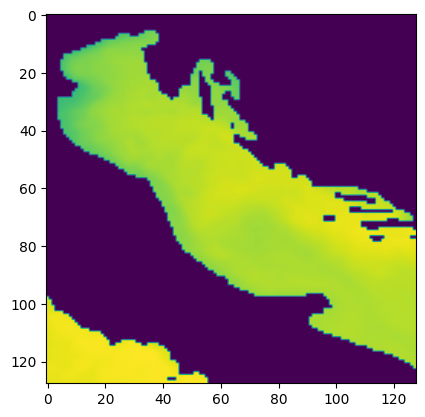

In [ ]:
i = np.random.randint(0, baseline.shape[0])
plt.imshow(baseline[i]); #nans are blank; they could be land or clouds

#### Count images for day

In [ ]:
# Convert timestamps to day of year
def convert_to_day_of_year(dates):
    # Convert Unix timestamps to datetime and then extract the day of year
    dates = pd.to_datetime(dates, unit='D', origin='unix')  # Convert to datetime
    return dates.dayofyear  # Extract day of year

# Convert each dataset
day_of_year_train = convert_to_day_of_year(dates_train_n)
day_of_year_val = convert_to_day_of_year(dates_val_n)
day_of_year_test = convert_to_day_of_year(dates_test_n)

# Count the number of images per day
def count_images_per_day(day_of_year):
    counts = np.bincount(day_of_year)
    return counts

# Count images per day for each dataset
counts_train = count_images_per_day(day_of_year_train)
counts_val = count_images_per_day(day_of_year_val)
counts_test = count_images_per_day(day_of_year_test)

# Print the counts
def print_counts(counts, label):
    print(f"\nNumber of images per day in {label}:")
    for day, count in enumerate(counts, start=1):
        if count > 0:  # Print only days with images
            print(f"Day {day}: {count} images")

print_counts(counts_train, 'Training Set')
print_counts(counts_val, 'Validation Set')
print_counts(counts_test, 'Test Set')

#### Histogram of pixel values distribution

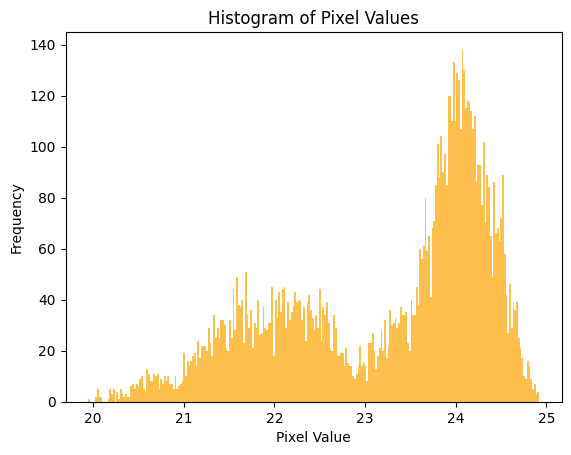

In [ ]:
i = np.random.randint(0, x_train_n[0].shape)
plt.hist(x_train_n[i].ravel(), bins=256, color='orange', alpha=0.7)
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.title('Histogram of Pixel Values')
plt.show()

#### Statistical tests to check normal distribution

In [ ]:
import numpy as np
from scipy.stats import shapiro, kstest

# Assume images is a list or array of images, where each image is a NumPy array
# Example: images = [img1, img2, img3, ...]

# Flatten all images and concatenate into a single large array
all_pixel_values = np.concatenate([img.ravel() for img in x_train_n])

# Remove NaN and infinite values
all_pixel_values = all_pixel_values[np.isfinite(all_pixel_values)]

# Check standard deviation to ensure variability
std_dev = np.std(all_pixel_values)
print(f"Standard Deviation of the dataset: {std_dev}")

# Proceed if there is enough variability
if std_dev > 0:
    # Apply the Kolmogorov-Smirnov Test
    stat, p_value = kstest(all_pixel_values, 'norm')
    print('Kolmogorov-Smirnov Test p-value:', p_value)

    # Apply Anderson-Darling Test for another check
    from scipy.stats import anderson
    result = anderson(all_pixel_values, dist='norm')
    print('Anderson-Darling Test statistic:', result.statistic)
    print('Anderson-Darling Test critical values:', result.critical_values)
else:
    print("Data is too uniform or contains very little variability.")


Standard Deviation of the dataset: 5.093420505523682
Kolmogorov-Smirnov Test p-value: 0.0
Anderson-Darling Test statistic: 314496.4611357935
Anderson-Darling Test critical values: [0.576 0.656 0.787 0.918 1.092]


> Even though data doesn't follow a normal distribution, applying Gaussian normalization is still effective.
>>In contrast, attempts to use different types of normalization, like MinMax Scaling, resulted in worse performance.

# Normalization
Gaussian (Z-Score) normalization

In [ ]:
x_train_mean = np.nanmean(x_train_n)
x_train_std = np.nanstd(x_train_n)

In [ ]:
x_train_n = (x_train_n - x_train_mean) / x_train_std
x_val_n = (x_val_n - x_train_mean) / x_train_std
x_test_n = (x_test_n - x_train_mean) / x_train_std

baseline_nan = np.where(land_sea_mask,baseline,np.nan)
baseline_nan = (baseline_nan - x_train_mean) / x_train_std
baseline = np.where(land_sea_mask,baseline_nan, 0.0)

> We are ensuring that the model operates within optimal conditions for gradient-based learning, avoiding issues that arise from inconsistent or extreme input values, preventing large disparities in feature scales, allowing the model to learn more efficiently and avoid issues like vanishing or exploding gradients during training.

> Moreover, when data is normalized, the optimizer can navigate the loss landscape more effectively, reducing the number of iterations required to reach convergence.

# Generator

A problem with occluded data is that we do not have ground truth available, as we do not know the actual sea temperature beneath the clouds.

To address this, we create an artificial ground truth by extending the clouded region. Specifically, we superimpose the clouds from a randomly chosen different day onto a given day, providing a configurable amount of auxiliary clouds.

In [11]:
def generator(batch_size, dataset, dates):
    size = 128
    while True:
        batch_x = np.zeros((batch_size, size, size, 4))
        batch_y = np.zeros((batch_size, size, size, 3))

        for b in range(batch_size):
            # Choose an image with a sufficiently large area of visible sea
            found = False
            while not found:
              i = np.random.randint(0, dataset.shape[0])
              visible = np.sum(~np.isnan(dataset[i])/total_sea)
              if visible > 0.4:
                found = True
            image_current = np.nan_to_num(dataset[i], nan=0)
            mask_current = np.isnan(dataset[i])

            # Extending clouds
            found = False
            while not found:
              r = np.random.randint(0, dataset.shape[0])
              mask_r = np.isnan(dataset[r])
              mask_or_r = np.logical_or(mask_current, mask_r)
              nnans = np.sum(~mask_or_r)/total_sea
              if nnans > 0.05 and nnans < min(visible-.1,0.4):
                found = True

            artificial_mask_current = ~mask_or_r  #1 visible, 0 masked

            # Apply the enlarged mask to the current day's image
            image_masked_current = np.where(artificial_mask_current, image_current, 0)

            # we tune the statistical baseline according to the average sea temperature of the current day

            # convert the current date to a datetime object using pandas
            date_series = pd.to_datetime(dates[i], unit='D', origin='unix')
            day_of_year = date_series.dayofyear

            #avg temp of the current day
            image_masked_nan = np.where(artificial_mask_current, image_current, np.nan)

            avg_temp_real = np.nanmean(image_masked_nan)
            avg_temp_baseline = np.nanmean(np.where(artificial_mask_current, baseline[day_of_year - 1],np.nan))
            tuned_baseline = baseline[day_of_year - 1] + avg_temp_real - avg_temp_baseline  # Adjust the baseline to match the average temperature of the current day
            tuned_baseline = np.where(land_sea_mask,tuned_baseline,.0)

            # Removing nans for usage in neural networks
            mask_current = np.logical_not(mask_current) # 1 for clear sea, 0 for land/clouds
            diff_mask = np.logical_and(~artificial_mask_current,mask_current) # 1 for clear sea, 0 for land/clouds and artificial clouds

            # Create batch_x and batch_y
            batch_x[b, ..., 0] = image_masked_current            #current artificially clouded image
            batch_x[b, ..., 1] = artificial_mask_current         #current artificial mask
            batch_x[b, ..., 2] = land_sea_mask                   #land-sea mask
            batch_x[b, ..., 3] = tuned_baseline                  #tuned baseline

            batch_y[b, ..., 0] = image_current                   #real image
            batch_y[b, ..., 1] = mask_current                    #real mask
            batch_y[b, ..., 2] = diff_mask                       #artificial mask used for the input

        yield batch_x, batch_y

Generators for gaussian normalized data

In [12]:
batch_size = 32

train_gen = generator(batch_size, x_train_n, dates_train_n)
val_gen = generator(batch_size, x_val_n, dates_val_n)
test_gen = generator(batch_size, x_test_n, dates_test_n)

The generator returns two sets of data, called batch_x and batch_y. The idea is that batch_x data are possible inputs for the neural network, while batch_y data provide ground_truth information that can be used for defining the loss function, or auxiliary metrics. Let us inspect them in more detail.

In [13]:
import matplotlib.pyplot as plt

def plot_elements(images, titles):

  num_of_images = len(images)
  rows = 1
  cols = num_of_images
  mini = np.nanmin(np.array(images))
  maxi = np.nanmax(np.array(images))
  print(mini,maxi)

  plt.figure(figsize=(10, 10*num_of_images))
  for i in range(num_of_images):
    print(f"image {i}; {np.min(images[i])}, {np.max(images[i])}")
    plt.subplot(rows, cols, i+1)
    plt.imshow(images[i],vmin=mini,vmax=maxi)
    plt.axis('off')
    plt.title(titles[i])
  plt.show()

0.0 27.32499858345335
image 0; 0.0, 27.32499858345335
image 1; 0.0, 27.22999936779661
image 2; 0.0, 26.457946525530787


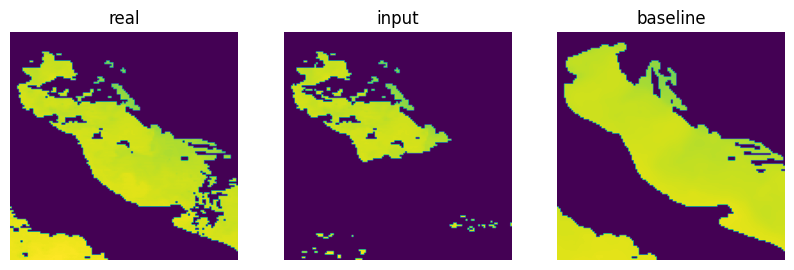

0.0 1.0
image 0; 0.0, 1.0
image 1; 0.0, 1.0
image 2; 0.0, 1.0


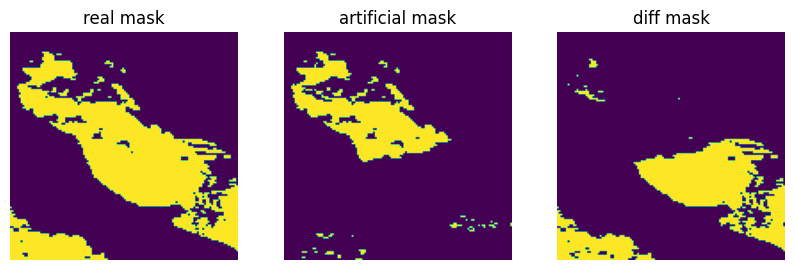

In [ ]:
batch_x, batch_y = next(test_gen)
assert(np.sum(np.isnan(batch_x))==0)
assert(np.sum(np.isnan(batch_y))==0)
real_denorm = np.where(batch_y[0,...,1],batch_y[0,...,0]*x_train_std + x_train_mean,0.0)
artificial_denorm = np.where(batch_x[0,...,1],batch_y[0,...,0]*x_train_std + x_train_mean,0.0)
baseline_denorm = np.where(land_sea_mask,batch_x[0,...,3]*x_train_std + x_train_mean,0.0)

plot_elements([real_denorm, artificial_denorm, baseline_denorm], ['real', 'input','baseline'])
plot_elements([batch_y[0,...,1], batch_x[0,...,1], batch_y[0,...,2]],["real mask","artificial mask","diff mask"])

In the first row, we see:
- the real image of the day
- the input passed to the model, that is a masked version of the previous image
- the tentative reconstruction done via the statistical baseline.

All images have been denormalized.

In the second row we see:
- the mask of the current day
- the enlarged masked with additional clouds
- the difference, showing the portion of the image visible in the first one, but occluded in the second. This is the region where the performance of the model must be evaluated




---



# Proposed solution

## Rationale behind preprocessing
The decision to rely solely on normalization in preprocessing was a personal choice, as the generator already implements an inherent filtering system. It selects images with sufficient sea visibility and applies artificial cloud masks, reducing the need for additional augmentations.

Normalization ensures consistent statistical properties, which is critical for comparing real and artificial data in the gap-filling task. More complex augmentations might distort these comparisons or introduce unwanted variability. Given the task's need for spatial coherence, further preprocessing was considered unnecessary.

This choice aligns with the specific requirements of the task without overcomplicating the data preparation process.

## The architecture: **U-Net**
I chose the U-Net architecture as the reference model for this gap-filling task due to its proven effectiveness in **image-to-image** translation problems, particularly in cases where precise localization and context are crucial, Indeed U-Net’s encoder-decoder structure allows for the extraction of both low-level and high-level features while **preserving spatial information** through skip connections. This is particularly valuable for gap-filling, where missing regions need to be inferred based on the surrounding pixel information. The **skip** connections in U-Net ensure that detailed spatial information from earlier layers is carried forward to the decoder, which helps maintain accuracy in predictions, especially along the edges of gaps. Additionally, the **flexibility** of the U-Net architecture enables the integration of various enhancements and modifications, making it highly adaptable to the specific requirements of several tasks.

The basic structure was indeed **modified** with specific design choices tailored to the needs of the gap-filling task, guided by theoretical principles:

#### **Dilated convolutions**
Dilated (Atrous) convolutions with varying dilation rates were introduced in the deeper layers.
The rationale behind this choice is that introducing dilated convolutions into the U-Net architecture enhances its ability to capture broader context without increasing computational cost or losing spatial resolution. This allows the model to effectively learn from a larger area of the input data, which is crucial for accurately filling gaps and preserving fine details in the output.

#### **Three-channels output**
A three-channel output was chosen in order to represent the prediction in multiple channels,
directly **aligning** with multi-channel **labels**. This setup can enhance the model's ability to handle complex output requirements and provides flexibility in interpreting and processing the results, and providing a richer representation of the predicted data.

#### **Attempt to incorporate Attention modules**
This was made to help the model focus more effectively on designated areas of the images. However, this resulted in slightly worse performance, though the approach still provided valuable insights.

## Best performing model

In [14]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

In [15]:
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128

In [ ]:
# definition of down_block
def down_block(inputs, filters, kernel_size=(3,3), padding='same', activation='relu', dilation_rate=(1, 1), kernel_initializer='he_normal', use_batch_norm=False, dropout_rate=0, weight_decay=1e-3):
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding, dilation_rate=dilation_rate, kernel_initializer=kernel_initializer, kernel_regularizer=l2(weight_decay))(inputs)
    if use_batch_norm:
        conv = BatchNormalization()(conv)
    if dropout_rate > 0:
        conv = Dropout(dropout_rate)(conv)
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding, dilation_rate=dilation_rate, kernel_initializer=kernel_initializer, kernel_regularizer=l2(weight_decay))(conv)

    if use_batch_norm:
        conv = BatchNormalization()(conv)
    if dropout_rate > 0:
        conv = Dropout(dropout_rate)(conv)
    pool = MaxPooling2D(pool_size=(2, 2))(conv)
    return conv, pool

# definition of up_block
def up_block(inputs, skip, filters, kernel_size=(3, 3), padding='same', activation='relu', dilation_rate=(1, 1), kernel_initializer='he_normal', use_batch_norm=False, dropout_rate=0, weight_decay=1e-4):
    up = UpSampling2D(size=(2, 2))(inputs)

    # Concatenate the upsampled features with the skip connection
    concat = Concatenate()([up, skip])

    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding, dilation_rate=dilation_rate, kernel_initializer=kernel_initializer, kernel_regularizer=l2(weight_decay))(concat)

    if use_batch_norm:
        conv = BatchNormalization()(conv)
    if dropout_rate > 0:
        conv = Dropout(dropout_rate)(conv)
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding, dilation_rate=dilation_rate, kernel_initializer=kernel_initializer, kernel_regularizer=l2(weight_decay))(conv)

    if use_batch_norm:
        conv = BatchNormalization()(conv)
    if dropout_rate > 0:
        conv = Dropout(dropout_rate)(conv)
    return conv

def unet(img_size=(IMAGE_HEIGHT, IMAGE_WIDTH), num_channels=4, output_channels=3, dilation_rate=(2, 2), kernel_initializer='he_normal', weight_decay=1e-4):
    inputs = Input(shape=img_size + (num_channels,))

    # Down Blocks
    conv1, pool1 = down_block(inputs, 32, kernel_initializer=kernel_initializer, weight_decay=weight_decay)
    conv2, pool2 = down_block(pool1, 64, kernel_initializer=kernel_initializer, weight_decay=weight_decay)
    conv3, pool3 = down_block(pool2, 128, dilation_rate=dilation_rate, kernel_initializer=kernel_initializer, use_batch_norm=True, weight_decay=weight_decay)
    conv4, pool4 = down_block(pool3, 256, dilation_rate=dilation_rate, kernel_initializer=kernel_initializer, use_batch_norm=True, weight_decay=weight_decay)

    # Bottleneck
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', dilation_rate=(3,3), kernel_initializer=kernel_initializer, kernel_regularizer=l2(weight_decay))(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', dilation_rate=(3,3), kernel_initializer=kernel_initializer, kernel_regularizer=l2(weight_decay))(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Dropout(0.4)(conv5)

    # Up Blocks
    conv6 = up_block(conv5, conv4, 256, dilation_rate=dilation_rate, kernel_initializer=kernel_initializer, use_batch_norm=True, dropout_rate=0.2, weight_decay=weight_decay)
    conv7 = up_block(conv6, conv3, 128, dilation_rate=dilation_rate, kernel_initializer=kernel_initializer, use_batch_norm=True, dropout_rate=0.2, weight_decay=weight_decay)
    conv8 = up_block(conv7, conv2, 64, kernel_initializer=kernel_initializer, weight_decay=weight_decay)
    conv9 = up_block(conv8, conv1, 32, kernel_initializer=kernel_initializer, weight_decay=weight_decay)

    # Output layer for continuous value prediction
    outputs = Conv2D(output_channels, (1, 1), activation='linear', padding="same", kernel_initializer=kernel_initializer)(conv9)

    model = Model(inputs=inputs, outputs=outputs, name="unet_deeper_relu")
    return model

# Build model
unet_relu = unet()

### **Comments about the architecture**
#### Batch Normalization, Dropout and Weight Decay
These regularization techniques were applied in the deeper layers. Specifically, dropout was avoided in the encoder to prevent negatively impacting the feature extraction process. In gap-filling tasks, where learning relies on intricate details and context, these techniques help the model generalize better, particularly in the deeper layers where more abstract features are learned. In conclusion, the same reasoning was applied to the weight decay application. Regularization is crucial for preventing overfitting to patterns seen during training, thus enabling the model to perform well on unseen, incomplete data.

#### Weight initialization
This architecture employs the 'he_normal' kernel initializer, which is particularly well-suited for layers with ReLU activation functions. This initializer adjusts the weight values based on the number of input units in the layer, helping to maintain a stable gradient flow during training. By normalizing weights, 'he_normal' helps prevent issues such as vanishing or exploding gradients, which can occur with other initializers. This initialization approach is advantageous in deep networks, as it contributes to faster convergence and more stable training, ultimately leading to better performance and generalization.

#### Overall structure
> Note that 3x3 filters were consistently used throughout the model to simplify the architecture and reduce the overall number of parameters.

As a classical u-net, the network employs a series of downsampling blocks with increasing filter sizes, which capture hierarchical features and reduce spatial dimensions. The bottleneck, with its deeper and more complex convolutional layers, captures high-level features and contextual information, allowing the model to learn complex patterns. The architecture features upsampling blocks with skip connections that concatenate high-resolution features from the encoder with the upsampled features. This helps in retaining fine-grained details lost during downsampling, which is critical for precise segmentation and gap-filling.


# Customize loss and metrics

### Customize loss: RMSE
By implementing a custom loss, I can specifically target the error computation (Root Mean Square Error) in regions of interest, guided by a mask present in the input data. This mask-driven method, which mirrors the approach used during the evaluation process, ensures that the model focuses on areas with missing or incomplete data. It optimizes predictions where they are needed most while avoiding unnecessary computations in regions where the values are already known.

In [ ]:
from tensorflow.keras.utils import register_keras_serializable

# keep this decorator to ensure that it is called when a model is loaded
@register_keras_serializable()
def custom_loss(y_true, y_pred):
    # Extract the mask from y_true (assuming mask is the last channel)
    mask = y_true[..., 2]

    # Extract the ground truth and predicted values for the temperature
    y_true_temp = y_true[..., 0]
    y_pred_temp = y_pred[..., 0]

    # Calculate the squared errors, only where the mask is 1
    squared_errors = tf.square(y_true_temp - y_pred_temp)
    masked_squared_errors = tf.multiply(squared_errors, mask)

    # Compute RMSE as the square root of mean squared errors
    rmse = tf.sqrt(tf.reduce_sum(masked_squared_errors) / tf.reduce_sum(mask))

    return rmse

#### Alternative loss that focuses on preserving already known values (performs equivalently)
This loss function is not utilized in the current model; however, it is retained for two reasons:
- future comparison purposes;
- emphasizing the effort to make the model retain known values
  - this approach was attempted and had some success, but the differences observed were relatively minor.

In [ ]:
@register_keras_serializable()
def custom_loss_penalizing(y_true, y_pred):
    # Extract the diff_mask from y_true (assuming it's the third channel)
    diff_mask = y_true[..., 2]

    # Create a complementary mask (1 - diff_mask)
    complementary_mask = 1 - diff_mask

    # Extract the ground truth values (first channel)
    y_true_temp = y_true[..., 0]

    # Calculate prediction error only in areas where diff_mask == 1 (areas to predict)
    errors = y_true_temp - y_pred[..., 0]
    masked_errors = tf.multiply(errors, diff_mask)

    # Preserve known values (areas where complementary_mask == 1)
    y_pred_preserved = tf.multiply(y_pred[..., 0], diff_mask) + tf.multiply(y_true_temp, complementary_mask)

    # Recalculate errors with preserved prediction
    errors_preserved = y_true_temp - y_pred_preserved
    masked_errors_preserved = tf.multiply(errors_preserved, diff_mask)

    # Calculate RMSE for the areas defined by diff_mask
    rmse = tf.sqrt(tf.reduce_sum(tf.square(masked_errors_preserved)) / (tf.reduce_sum(diff_mask) + tf.keras.backend.epsilon()))

    # Penalize changes to known values
    penalty = tf.reduce_sum(tf.square(y_pred_preserved - y_true_temp) * complementary_mask)

    # Combine RMSE and penalty
    loss = rmse + 0.8 * penalty

    return loss

### Customize metric: MAE

Similarly, I defined a custom metric to monitor training from a different perspective, specifically calculating the Mean Absolute Error (MAE) only in the gap areas. This approach also allows for a more focused evaluation of model performance on the regions where predictions are crucial.

In [ ]:
@register_keras_serializable()
def custom_mae(y_true, y_pred):
    # Ensure tensors are of the same type
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Extract the mask from y_true (assuming mask is the last channel)
    mask = y_true[..., 2]

    # Extract the ground truth and predicted values for the temperature
    y_true_temp = y_true[..., 0]
    y_pred_temp = y_pred[..., 0]

    # Calculate absolute errors
    absolute_errors = tf.abs(y_true_temp - y_pred_temp)

    # Apply the mask
    masked_absolute_errors = tf.multiply(absolute_errors, mask)

    # Compute the mean absolute error
    mae = tf.reduce_sum(masked_absolute_errors) / (tf.reduce_sum(mask) + tf.keras.backend.epsilon())

    return mae


# Training

## Choose the model

In [ ]:
model = unet_relu

### Customize callbacks

These callbacks were chosen for the following reasons:
* *ReduceLROnPlateau*: adjusts the learning rate when validation loss plateaus, helping the model refine its learning in the face of stagnation. This callback proved to be crucial during the training procedure, as it allowed the model to make meaningful progress when improvement slowed down.

* *EarlyStopping*: halts training when validation loss stops improving, preventing overfitting and saving the best-performing model.

* *ExponentialMovingAverage* (*EMA*): smooths the model’s weights to improve generalization and stability by averaging past weights, enhancing performance on new data.

In [ ]:
from tensorflow.keras.callbacks import Callback

class ExponentialMovingAverage(tf.keras.callbacks.Callback):
    def __init__(self, decay=0.9):
        super(ExponentialMovingAverage, self).__init__()
        self.decay = decay
        self.ema_weights = []

    def on_train_begin(self, logs=None):
        # Initialize EMA weights
        self.ema_weights = [tf.Variable(tf.identity(w), trainable=False) for w in self.model.trainable_weights]

    def on_epoch_end(self, epoch, logs=None):
        # Update EMA weights
        for w, ema_w in zip(self.model.trainable_weights, self.ema_weights):
            ema_w.assign(self.decay * ema_w + (1 - self.decay) * w)

ema_callback = ExponentialMovingAverage()

custom_callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10),
    ema_callback
]

## Compile the model

In [ ]:
# Training Config
LEARNING_RATE = 1e-3

model.compile(
    optimizer=keras.optimizers.Adam(LEARNING_RATE), loss=custom_loss, metrics=[custom_mae])

## Fit the model

In [ ]:
# Number of samples in your training and validation sets
total_train_samples = len(x_train_n)  # Total number of samples in training
total_val_samples = len(x_val_n)      # Total number of samples in validation

# Calculate steps per epoch and validation steps
steps_per_epoch = total_train_samples // batch_size - 32
validation_steps = total_val_samples // batch_size

# set num of epochs
EPOCHS = 90

# Train the model
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_gen,
    validation_steps=total_val_samples,
    callbacks=custom_callbacks
)

Epoch 1/90


I0000 00:00:1725926599.530769     135 service.cc:145] XLA service 0x7d7ad4005bf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725926599.530850     135 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1725926599.530857     135 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1725926639.778158     135 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


150/150 ━━━━━━━━━━━━━━━━━━━━ 139s 585ms/step - custom_mae: 0.2245 - loss: 0.8514 - val_custom_mae: 0.0993 - val_loss: 0.5315 - learning_rate: 0.0010
Epoch 2/90
150/150 ━━━━━━━━━━━━━━━━━━━━ 85s 568ms/step - custom_mae: 0.1067 - loss: 0.4934 - val_custom_mae: 0.0998 - val_loss: 0.3698 - learning_rate: 0.0010
Epoch 3/90
150/150 ━━━━━━━━━━━━━━━━━━━━ 85s 571ms/step - custom_mae: 0.1049 - loss: 0.3503 - val_custom_mae: 0.1055 - val_loss: 0.2880 - learning_rate: 0.0010
Epoch 4/90
150/150 ━━━━━━━━━━━━━━━━━━━━ 83s 554ms/step - custom_mae: 0.1061 - loss: 0.2769 - val_custom_mae: 0.1042 - val_loss: 0.2377 - learning_rate: 0.0010
Epoch 5/90
150/150 ━━━━━━━━━━━━━━━━━━━━ 83s 556ms/step - custom_mae: 0.1009 - loss: 0.2299 - val_custom_mae: 0.0919 - val_loss: 0.2006 - learning_rate: 0.0010
Epoch 6/90
150/150 ━━━━━━━━━━━━━━━━━━━━ 80s 539ms/step - custom_mae: 0.0968 - loss: 0.2039 - val_custom_mae: 0.0937 - val_loss: 0.1864 - learning_rate: 0.0010
Epoch 7/90
150/150 ━━━━━━━━━━━━━━━━━━━━ 80s 538ms/step -

> Over the first 60 epochs of training, the model demonstrated a consistent improvement in performance. Initially, the training loss decreased from 0.8514 in Epoch 1 to 0.4934 by Epoch 2, reflecting the model's enhanced ability to minimize errors. By Epoch 10, the loss had further reduced to 0.1542, indicating a stable and ongoing learning process. The validation loss also followed a similar trend, dropping from 0.5315 in Epoch 1 to 0.1161 by Epoch 40. This suggests that the model is generalizing well to unseen data. The custom MAE metric showed an initial decrease and then stabilized, with slight fluctuations, while the learning rate was adjusted according to the specified schedule.
>> By Epoch 60, the model had effectively **converged**, achieving a validation loss of 0.1107 and maintaining a low MAE of 0.0692.

>> The learning rate adjustments due to the ReduceLROnPlateu callback
assist in refining the model's performance as it converges, ensuring a more gradual learning process and stabilization of loss values.
>>> Overall, the results indicate that the model is **learning effectively** and **generalizing well**, with steady improvements in both training and validation metrics.

# Evaluation

The model must be evaluted by means of the following function, calling the test generator 50 times. The metrics adopted is the Rooted Mean Squared Error (RMSE).

To make a running example, we measure the performance of the statistical
baseline.

In [ ]:
def evaluate_model(model, test_gen=test_gen)
    # Initialize lists to store the errors and the maximum errors
    RMSE = []

    # Generate and evaluate tot batches
    tot = 50
    for _ in range(tot):
        # Generate a batch
        batch_x, batch_y = next(test_gen)
        #uncomment the next line and call your model
        predictions = model.predict(batch_x, verbose=0)
        #predictions = batch_x[...,3] #use the baseline as prediction

        predictions = predictions[...,0]

        # Denormalize data !!!
        predictions_denorm = predictions*x_train_std + x_train_mean
        true_values_denorm = batch_y[..., 0]*x_train_std + x_train_mean

        # Get the masks and calculate the errors
        diffMask = batch_y[..., 2]
        diff_errors_batch = np.where(diffMask, np.abs(predictions_denorm - true_values_denorm), np.nan)
        squared_errors = np.nanmean(diff_errors_batch**2,axis=(1,2))
        RMSE.append(np.sqrt(squared_errors))

    RMSE = np.concatenate(RMSE)

    return RMSE

RMSE = evaluate_model(model)
print(f"RMSE :", np.mean(RMSE))
print(f"RMSE std :", np.std(RMSE))

RMSE : 0.4688377418560035
RMSE std : 0.14386117319108366


> The average RMSE computed over 50 batches using the model's predictions is significantly **lower than the RMSE obtained with the statistical baseline as the prediction**. This suggests that the model performs very well, as it provides more accurate predictions compared to the baseline. The reduced RMSE indicates that the model effectively captures and corrects the nuances in the data, leading to a more precise gap-filling result than the simpler statistical approach.
>>This performance is a strong validation of the model’s capability to **improve upon the baseline**.

# Save weights and the model

In [ ]:
# Save the model weights to a file
#model.save_weights('/kaggle/working/relu_90_epochs.weights.h5')

# Save the complete model
#model.save('/kaggle/working/relu_deep.keras')

# Load weights / models
if necessary

In [ ]:
model = unet_relu()
#model.load_weights('')

In [ ]:
# not defined here in this notebook
model_to_compare = unet_attention()

In [ ]:
weights_path = " "
model_to_compare.load_weights(weights_path)

# Visualize results

Let's visually compare the predicted image with the ground truth. Additionally, the prediction from the best model with attention modules is displayed for comparison.

0.0 17.95999911053883
image 0; 0.0, 17.95999911053883
image 1; 0.0, 17.95999911053883


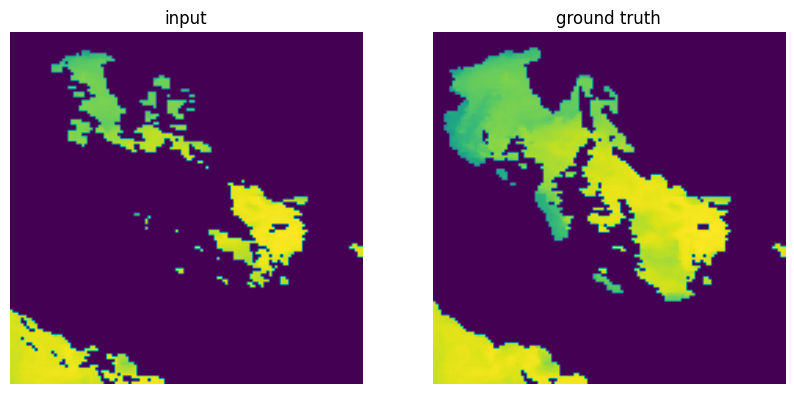

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
0.0 18.01235
image 0; 0.0, 18.01235008239746
image 1; 0.0, 17.956710815429688


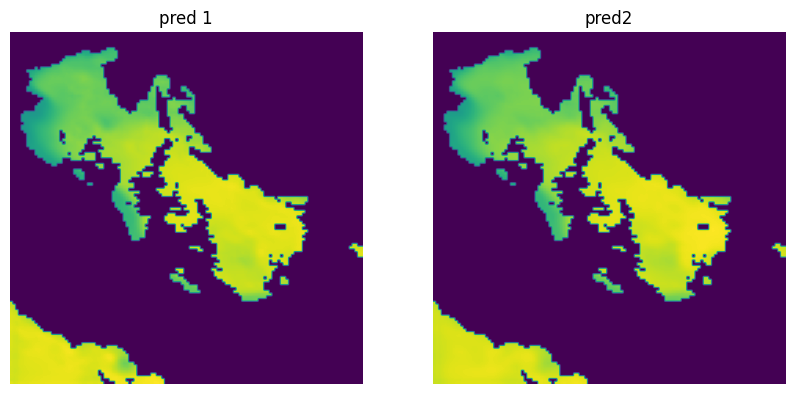

In [ ]:
x, y = next(test_gen)

real_denorm = np.where(y[0,...,1], y[0,...,0] * x_train_std + x_train_mean,0.0)
artificial_denorm = np.where(x[0,...,1], y[0,...,0] * x_train_std + x_train_mean,0.0)
plot_elements([artificial_denorm, real_denorm], ['input','ground truth'])

pred_1 = model.predict(x)
pred_2 = model_to_compare.predict(x)
pred_denorm_1 = np.where(y[0,...,1], pred_1[0,...,0] * x_train_std + x_train_mean,0.0)
pred_denorm_2 = np.where(y[0,...,1], pred_2[0,...,0] * x_train_std + x_train_mean,0.0)
plot_elements([pred_denorm_1, pred_denorm_2], ['pred 1','pred2'])

>As observed, the predictions closely resemble the ground truth.
>>Specifically, the predicted image from my best model visually mirrors the temperature values represented by the ground truth.
>>>However, the model with additional attention modules smooths the intensities even more. This occurs because attention mechanisms can act as a form of regularization, encouraging the model to generalize better. As a result, the model may produce smoother predictions to avoid overfitting to noise or irregularities in the training data.

### Plot metrics and losses

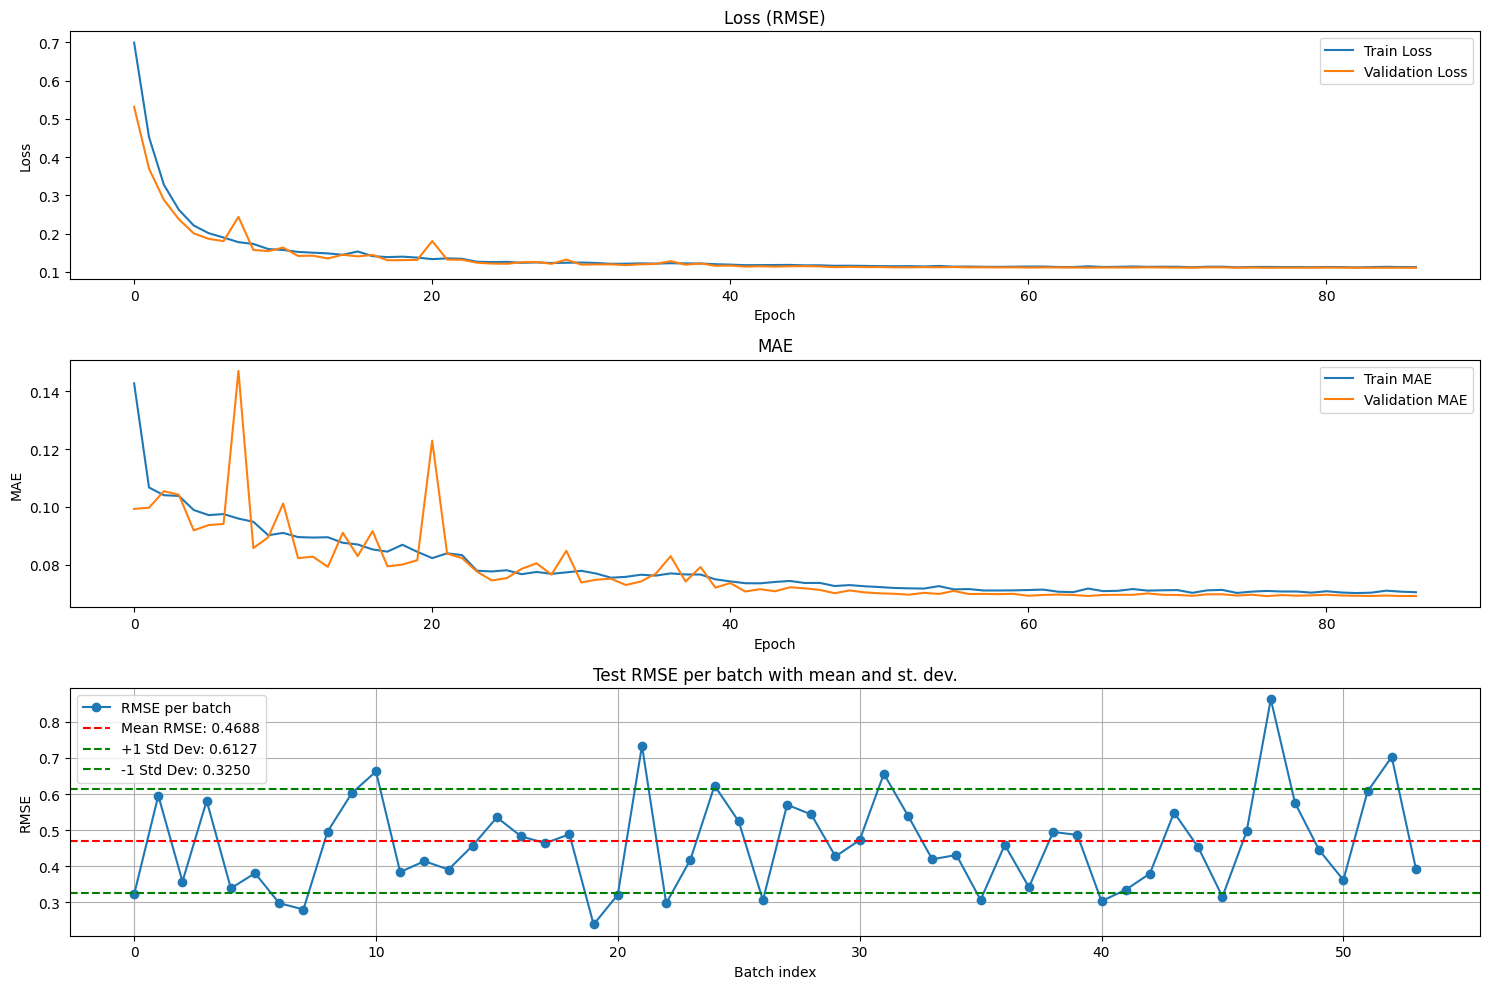

In [ ]:
import matplotlib.pyplot as plt

# Extract data from the history object
history_dict = history.history

# Loss
loss = history_dict.get('loss')
val_loss = history_dict.get('val_loss')

# MSE
mae = history_dict.get('custom_mae')
val_mae = history_dict.get('val_custom_mae')

# RMSE values
mean_rmse = np.mean(RMSE)
std_rmse = np.std(RMSE)
n = 30  # downsample
RMSE_sub = RMSE[::n]

# Plot Loss
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss (RMSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(3, 1, 2)
plt.plot(mae, label='Train MAE')
plt.plot(val_mae, label='Validation MAE')
plt.title('MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Plot Test RMSE
# Create the plot
plt.subplot(3, 1, 3)
plt.plot(RMSE_sub, label='RMSE per batch', marker='o')
plt.axhline(y=mean_rmse, color='r', linestyle='--', label=f'Mean RMSE: {mean_rmse:.4f}')
plt.axhline(y=mean_rmse + std_rmse, color='g', linestyle='--', label=f'+1 Std Dev: {mean_rmse + std_rmse:.4f}')
plt.axhline(y=mean_rmse - std_rmse, color='g', linestyle='--', label=f'-1 Std Dev: {mean_rmse - std_rmse:.4f}')

# Adding labels and title
plt.title('Test RMSE per batch with mean and st. dev.')
plt.xlabel('Batch index')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

> The first two plots shows all of which we talked about previously.

> The last plot provide interesting insights about the average RMSE computed on the test set; in particular it shows how the RMSE computed on each test batch fluctuates around the mean RMSE.

# Extra: further comparisons

In [ ]:
# it uses the custom_loss defined above
attention_simple_loss = unet_attention(img_size=(128, 128), num_channels=4, output_channels=3, kernel_initializer='he_normal')
weights_path = "/kaggle/input/attention_model/keras/default/1/attention_relu_2_90_epochs.weights.h5"
attention_simple_loss.load_weights(weights_path)

In [ ]:
# it uses the second version of the loss: 'custom_loss_penalizing' but with just a 70 epochs run
attention_complex_loss = unet_attention(img_size=(128, 128), num_channels=4, output_channels=3, kernel_initializer='he_normal')
weights_path = "/kaggle/input/attention_relu/transformers/default/1/attention_relu_3_70_epochs.weights.h5"
attention_complex_loss.load_weights(weights_path)

In [ ]:
# evaluate models
RMSE_1 = evaluate_model(attention_simple_loss)
RMSE_2 = evaluate_model(attention_complex_loss)

In [ ]:
RMSE_dict = {
    "best_unet": np.mean(RMSE),
    "attention_simple_loss": np.mean(RMSE_1),
    "attention_complex_loss": np.mean(RMSE_2)
}

# Convert dictionary to DataFrame
df = pd.DataFrame(list(RMSE_dict.items()), columns=['Model', 'avg RMSE'])
display(df)

,Model,avg RMSE
0,best_unet,0.468838
1,attention_simple_loss,0.472282
2,attention_complex_loss,0.478062


> Results are indeed very good, consdiering all variants.

#### Additional attempts (not dislayed)

Several experiments were conducted, but none achieved the same results as the U-Net model described above. The modified version of the U-Net with an attention module was the only model that yielded promising outcomes. On average, it produced more stable results, but it never achieved an average RMSE below 0.47, unlike the proposed U-Net. Other unsuccessful experiments included:

* Using Transposed Convolutions instead of UpSampling layers, which resulted in a higher number of learnable parameters but did not improve the outcome.
* Shallower architectures, reducing the model depth led to slightly worse performance
* Lightweight versions, which failed to capture the inherent patterns effectively.